In [1]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import json
import os
import glob
from lxml import etree

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


Mounted at /content/drive


In [2]:
# File paths
main_directory = "/content/drive/My Drive/266_NLP/final project/"
model_directory = "/content/drive/My Drive/266_NLP/final project/models/e5-base-v2/"
output_csv = "/content/drive/My Drive/266_NLP/final project/uspto_patents_cpc_metadata.csv"


In [ ]:
import os
import glob
from lxml import etree
import json
import pandas as pd

def extract_all_claims(root):
    claims = root.findall(".//claims/claim")
    all_claims = []
    for claim in claims:
        parts = claim.findall(".//claim-text")
        claim_text = " ".join(p.text.strip() for p in parts if p.text)
        all_claims.append(claim_text)  # Removed claim_number
    return all_claims

def extract_patent_metadata(xml_path):
    try:
        tree = etree.parse(xml_path)
        root = tree.getroot()

        def gettext(xpath):
            el = root.find(xpath)
            return el.text.strip() if el is not None and el.text else None

        def getalltext(xpath):
            els = root.findall(xpath)
            return [el.text.strip() for el in els if el is not None and el.text]

        # Fetch all parts together
        sections = getalltext(".//classification-cpc/section")
        classes = getalltext(".//classification-cpc/class")
        subclasses = getalltext(".//classification-cpc/subclass")
        main_groups = getalltext(".//classification-cpc/main-group")
        subgroups = getalltext(".//classification-cpc/subgroup")

        # Zip CPC levels to produce full identifiers
        cpc_entries = list(zip(sections, classes, subclasses, main_groups, subgroups))

        def safe_join(*parts, sep=""):
            return sep.join(p for p in parts if p)

        metadata = {
            "file": os.path.basename(xml_path),
            "publication_number": gettext(".//publication-reference/document-id/doc-number"),
            "application_number": gettext(".//application-reference/document-id/doc-number"),
            "publication_date": gettext(".//publication-reference/document-id/date"),
            "application_date": gettext(".//application-reference/document-id/date"),
            "invention_title": gettext(".//invention-title"),

            # Construct full identifiers
            "section": sorted(set(sections)),
            "class": sorted(set(safe_join(s, c) for s, c, _, _, _ in cpc_entries if s and c)),
            "subclass": sorted(set(safe_join(s, c, sc) for s, c, sc, _, _ in cpc_entries if s and c and sc)),
            "main_group": sorted(set(safe_join(s, c, sc, mg) for s, c, sc, mg, _ in cpc_entries if s and c and sc and mg)),
            "subgroup": sorted(set(safe_join(s, c, sc, mg, "-" + sg) for s, c, sc, mg, sg in cpc_entries if s and c and sc and mg and sg)),

            "country": gettext(".//country"),
            "abstract": gettext(".//abstract/p"),
            "assignee": gettext(".//assignees/assignee/addressbook/orgname"),
            "inventor_1": gettext(".//inventors/inventor[1]/addressbook/last-name"),
            "inventor_2": gettext(".//inventors/inventor[2]/addressbook/last-name"),
            "claims": extract_all_claims(root),
        }

        return metadata
    except Exception as e:
        return {"file": os.path.basename(xml_path), "error": str(e)}


def extract_from_directory(directory):
    xml_files = glob.glob(os.path.join(directory, "*.xml"))
    print(f"Found {len(xml_files)} XML files in {directory}")
    return [extract_patent_metadata(path) for path in xml_files]

if not os.path.exists(output_csv):

  # Extract
  records = extract_from_directory(directory)

  # Save CSV
  df = pd.DataFrame(records)
  df["section"] = df["section"].apply(lambda x: ",".join(sorted(set(x))) if isinstance(x, list) else x)
  df["claims"] = df["claims"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
  df["combined_text"] = (
      df["invention_title"].fillna("") + " " +
      df["abstract"].fillna("") + " " +
      df["claims"]
  ).str.lower()

  df.to_csv(output_csv, index=False)

  print(f"Extracted {len(records)} files. Saved to JSON and CSV.")
  del records

In [3]:
df_all=pd.read_csv(main_directory + "uspto_patents_cpc_metadata.csv")
df_all = df_all.dropna(subset=['section'])
df_cleaned, test_df = train_test_split(df_all, test_size=0.20, random_state=42)

df_cleaned = df_cleaned.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

df_cleaned.head()



,file,publication_number,application_number,publication_date,application_date,invention_title,section,class,subclass,main_group,subgroup,country,assignee,inventor_1,abstract,claims,combined_text
0,doc_1371.xml,20250195720,18544429,20250619,20231219,SILICONE OIL IN WATER INJECTABLE FILLER COMPOS...,"A,C","['A61', 'C08']","['A61L', 'C08L']","['A61L2300', 'A61L2400', 'A61L2430', 'A61L27',...","['A61L2300-402', 'A61L2300-428', 'A61L2400-06'...",US,NaN,Mezzancello,A silicone oil in water composition that is an...,1. An injectable filler composition that can b...,silicone oil in water injectable filler compos...
1,doc_8236.xml,20250202385,19066028,20250619,20250227,"CONTROL APPARATUS OF VIBRATION ACTUATOR, CONTR...",H,['H02'],['H02N'],['H02N2'],['H02N2-142'],US,NaN,MORITA,A control unit of a control apparatus for a vi...,1. A control apparatus of a vibration actuator...,"control apparatus of vibration actuator, contr..."
2,doc_17822.xml,12335647,18529767,20250617,20231205,Time-resolving computational image sensor arch...,H,['H04'],['H04N'],['H04N25'],"['H04N25-745', 'H04N25-75', 'H04N25-771']",US,"Samsung Electronics Co., Ltd.",Wang,A pixel for an image sensor includes a photon ...,1. A method for processing imaging data from a...,time-resolving computational image sensor arch...
3,doc_9647.xml,20250203796,18981576,20250619,20241215,Cover for Electrical Devices,H,['H05'],['H05K'],['H05K5'],"['H05K5-0217', 'H05K5-03']",US,NaN,JADE,The present invention provides a cover assembl...,1. A cover assembly (100) for an electrical de...,cover for electrical devices the present inven...
4,doc_5623.xml,20250199775,18543282,20250619,20231218,DESIGN TIME SMART ANALYZER AND RUNTIME SMART H...,G,['G06'],['G06F'],['G06F8'],"['G06F8-34', 'G06F8-35']",US,"UiPath, Inc.",GRIGORE,A design time smart analyzer and a runtime sma...,1. A non-transitory computer-readable medium s...,design time smart analyzer and runtime smart h...


In [6]:
import numpy as np
from sentence_transformers import SentenceTransformer

if not os.path.exists(model_directory + "e5-base-v2_embeddings_df_cleaned.npy"):
  # Initialize embedding model
  embedder = SentenceTransformer("intfloat/e5-base-v2")
  #Create embeddings
  embeddings = embedder.encode(df_cleaned["combined_text"].tolist())
  np.save(model_directory + "e5-base-v2_embeddings_df_cleaned.npy", embeddings)
else:
    print("Embeddings already exist for df_cleaned split.")
    embeddings = np.load(model_directory + "e5-base-v2_embeddings_df_cleaned.npy")

print(embeddings.shape)

Embeddings already exist for df_cleaned split.
(13746, 768)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

# Step 1: Preprocess labels (multi-label binarization)
# The filtering for missing 'section' values was already done when creating df_cleaned from df_all
# No need to dropna again here.

# Split section into list (if it's a comma-separated string)
df_cleaned['section_list'] = df_cleaned['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Binarize multi-label output
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H", "Y"])
Y = mlb.fit_transform(df_cleaned["section_list"])


# Step 2: Train-test split
# Since embeddings were created from df_cleaned (after the initial split and dropping missing sections),
# we can use the index of this df_cleaned directly as it corresponds to the embeddings.
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, test_size=0.5, random_state=42
)

# Step 3: Train a One-vs-Rest classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = clf.predict(X_test)
print("Multi-label Section Classification Report (OneVsRestClassifier/RFC) on df_cleaned split without finetuned embeddings:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Multi-label Section Classification Report (OneVsRestClassifier/RFC) on df_cleaned split without finetuned embeddings:

              precision    recall  f1-score   support

           A       0.92      0.35      0.51      1312
           B       0.88      0.09      0.17      1214
           C       0.88      0.35      0.50       771
           D       0.00      0.00      0.00        49
           E       0.00      0.00      0.00       199
           F       1.00      0.05      0.09       500
           G       0.81      0.67      0.73      2445
           H       0.88      0.59      0.71      2415
           Y       1.00      0.02      0.04        47

   micro avg       0.85      0.44      0.58      8952
   macro avg       0.71      0.24      0.31      8952
weighted avg       0.85      0.44      0.54      8952
 samples avg       0.53      0.49      0.50      8952



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# Use a logistic regression based classifier
from sklearn.linear_model import LogisticRegression

clf = OneVsRestClassifier(LogisticRegression(
    max_iter=1000,
    solver='lbfgs'
))
clf.fit(X_train, y_train)

# ------------------------------------------------
# STEP 5: Predict & Evaluate
# ------------------------------------------------

y_pred = clf.predict(X_test)

# Optional: per-class report
print("Multi-label LogisticRegression Section Classification Report on df_cleaned split without finetuned embeddings:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


Multi-label LogisticRegression Section Classification Report on df_cleaned split without finetuned embeddings:
              precision    recall  f1-score   support

           A       0.87      0.79      0.83       647
           B       0.76      0.59      0.66       622
           C       0.86      0.67      0.75       367
           D       0.60      0.10      0.17        30
           E       0.66      0.56      0.60        99
           F       0.74      0.55      0.63       226
           G       0.84      0.77      0.80      1256
           H       0.88      0.77      0.82      1270
           Y       0.00      0.00      0.00        31

   micro avg       0.84      0.71      0.77      4548
   macro avg       0.69      0.53      0.59      4548
weighted avg       0.83      0.71      0.77      4548
 samples avg       0.86      0.78      0.80      4548



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# -------------------------
# XGBoost Model
# -------------------------
from xgboost import XGBClassifier

xgb_params = {
    "objective": "binary:logistic",  # Required for multilabel
    "eval_metric": "logloss",
    "use_label_encoder": False,
    "n_estimators": 100,
    "max_depth": 5,
    "learning_rate": 0.1,
}

clf = OneVsRestClassifier(XGBClassifier(**xgb_params))
clf.fit(X_train, y_train)

# -------------------------
# Step 5: Prediction
# -------------------------
y_pred = clf.predict(X_test)

print("Multi-label XGBoost Section Classification Report on df_cleaned split without finetuned embeddings:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:05:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:05:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:05:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:05:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:05:29] WARNING: /w

Multi-label XGBoost Section Classification Report on df_cleaned split without finetuned embeddings:
              precision    recall  f1-score   support

           A       0.88      0.62      0.72      1312
           B       0.76      0.36      0.49      1214
           C       0.81      0.63      0.71       771
           D       1.00      0.06      0.12        49
           E       0.75      0.09      0.16       199
           F       0.81      0.29      0.42       500
           G       0.80      0.75      0.77      2445
           H       0.83      0.72      0.77      2415
           Y       0.00      0.00      0.00        47

   micro avg       0.82      0.61      0.70      8952
   macro avg       0.74      0.39      0.46      8952
weighted avg       0.81      0.61      0.68      8952
 samples avg       0.70      0.66      0.66      8952



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


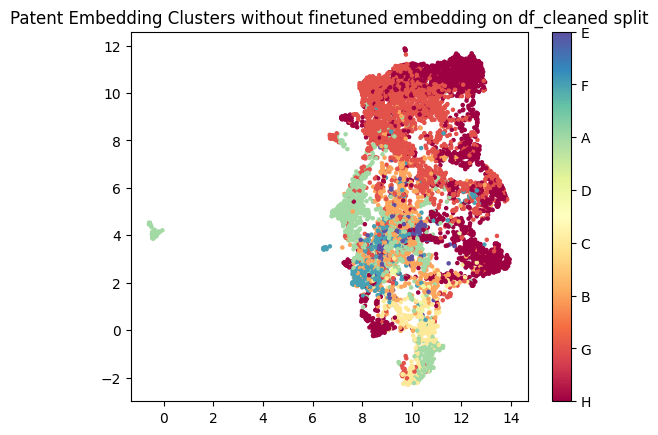

In [ ]:
import umap
import matplotlib.pyplot as plt

valid_sections = list("ABCDEFGHY")
df_cleaned_tmp = df_cleaned[df_cleaned["section"].isin(valid_sections)]

reducer = umap.UMAP(n_neighbors=15, random_state=42)
# Compute UMAP projection only on embeddings corresponding to df_cleaned
proj = reducer.fit_transform(embeddings[df_cleaned_tmp.index])

# Define labels for coloring the scatter plot
labels = df_cleaned_tmp["section"]

# Map string labels to numerical values
unique_labels = labels.unique()
label_map = {label: i for i, label in enumerate(unique_labels)}
numerical_labels = labels.map(label_map)


plt.scatter(proj[:,0], proj[:,1], c=numerical_labels, cmap='Spectral', s=5)
plt.title("Patent Embedding Clusters without finetuned embedding on df_cleaned split")
# Add a colorbar to show the mapping of colors to sections
cbar = plt.colorbar(ticks=np.arange(len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)
plt.show()

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer

if not os.path.exists(model_directory + "e5-base-v2_embeddings_test_df.npy"):
  # Initialize embedding model
  embedder = SentenceTransformer("intfloat/e5-base-v2")
  #Create embeddings
  embeddings = embedder.encode(test_df["combined_text"].tolist())
  np.save(model_directory + "e5-base-v2_embeddings_test_df.npy", embeddings)
else:
    print("Embeddings already exist for test_df split.")
    embeddings = np.load(model_directory + "e5-base-v2_embeddings_test_df.npy")

print(embeddings.shape)

Embeddings already exist for test_df split.
(3437, 768)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

# Step 1: Preprocess labels (multi-label binarization)

# Split section into list (if it's a comma-separated string)
test_df['section_list'] = test_df['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Binarize multi-label output
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H", "Y"])
Y = mlb.fit_transform(test_df["section_list"])


# Step 2: Train-test split
# Since embeddings were created from df_cleaned (after the initial split and dropping missing sections),
# we can use the index of this df_cleaned directly as it corresponds to the embeddings.
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, test_size=0.5, random_state=42
)

# Step 3: Train a One-vs-Rest classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = clf.predict(X_test)
print("Multi-label Section Classification Report (OneVsRestClassifier) on test_df split without finetuned embeddings:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Multi-label Section Classification Report (OneVsRestClassifier) on test_df split without finetuned embeddings:

              precision    recall  f1-score   support

           A       0.89      0.26      0.41       314
           B       0.83      0.03      0.06       314
           C       0.89      0.18      0.30       186
           D       0.00      0.00      0.00        19
           E       0.00      0.00      0.00        49
           F       1.00      0.04      0.07       109
           G       0.77      0.65      0.71       599
           H       0.87      0.55      0.67       634
           Y       0.00      0.00      0.00        18

   micro avg       0.82      0.39      0.53      2242
   macro avg       0.58      0.19      0.25      2242
weighted avg       0.82      0.39      0.47      2242
 samples avg       0.47      0.43      0.44      2242



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Use a logistic regression based classifier
from sklearn.linear_model import LogisticRegression

clf = OneVsRestClassifier(LogisticRegression(
    max_iter=1000,
    solver='lbfgs'
))
clf.fit(X_train, y_train)

# ------------------------------------------------
# STEP 5: Predict & Evaluate
# ------------------------------------------------

y_pred = clf.predict(X_test)
print("Multi-label LogisticRegression Section Classification Report on test_df split without finetuned embeddings:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Multi-label LogisticRegression Section Classification Report on test_df split without finetuned embeddings:

              precision    recall  f1-score   support

           A       0.92      0.41      0.57       314
           B       0.93      0.08      0.15       314
           C       0.86      0.13      0.22       186
           D       0.00      0.00      0.00        19
           E       0.00      0.00      0.00        49
           F       0.00      0.00      0.00       109
           G       0.75      0.68      0.72       599
           H       0.83      0.66      0.73       634
           Y       0.00      0.00      0.00        18

   micro avg       0.81      0.45      0.58      2242
   macro avg       0.48      0.22      0.27      2242
weighted avg       0.76      0.45      0.52      2242
 samples avg       0.54      0.50      0.50      2242



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# -------------------------
# XGBoost Model
# -------------------------
from xgboost import XGBClassifier

xgb_params = {
    "objective": "binary:logistic",  # Required for multilabel
    "eval_metric": "logloss",
    "use_label_encoder": False,
    "n_estimators": 100,
    "max_depth": 5,
    "learning_rate": 0.1,
}

clf = OneVsRestClassifier(XGBClassifier(**xgb_params))
clf.fit(X_train, y_train)

# -------------------------
# Step 5: Prediction
# -------------------------
y_pred = clf.predict(X_test)

print("Multi-label XGBoost Section Classification Report on test_df split without finetuned embeddings:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:07:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:07:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:07:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:07:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:07:29] WARNING: /w

Multi-label XGBoost Section Classification Report on test_df split without finetuned embeddings:

              precision    recall  f1-score   support

           A       0.83      0.55      0.66       314
           B       0.73      0.25      0.37       314
           C       0.83      0.51      0.63       186
           D       1.00      0.05      0.10        19
           E       0.67      0.04      0.08        49
           F       0.91      0.18      0.31       109
           G       0.75      0.73      0.74       599
           H       0.81      0.69      0.74       634
           Y       0.00      0.00      0.00        18

   micro avg       0.79      0.55      0.65      2242
   macro avg       0.72      0.33      0.40      2242
weighted avg       0.78      0.55      0.62      2242
 samples avg       0.63      0.60      0.59      2242



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Balancing classes
import os
import pandas as pd
from itertools import combinations
import random
from collections import defaultdict

build_df_pairs = False

if os.path.exists(main_directory + "df_pairs.csv"):
    print("Loading existing df_pairs.csv ...")
    df_pairs = pd.read_csv(main_directory + "df_pairs.csv")
else:
    print("df_pairs.csv does not exist. Building...")
    build_df_pairs = True

if build_df_pairs:
    # ------------------------------------------------------
    # STEP 1 — Group publications by labels
    # ------------------------------------------------------
    label_to_pubs = defaultdict(list)
    all_pubs = set()

    for row in df_cleaned.itertuples(index=False):
        pub_number = row.publication_number
        all_pubs.add(pub_number)
        for label in row.section.split(','):
            label_to_pubs[label.strip()].append(pub_number)

    print("Label → # publications mapping:")
    for label, pubs in label_to_pubs.items():
        print(f"Label {label}: {len(pubs)} publications")

    # ------------------------------------------------------
    # STEP 2 — Generate positive pairs, balanced per label
    # ------------------------------------------------------
    max_pos_pairs_per_class = 2000
    positive_pairs = []

    for label, pub_list in label_to_pubs.items():
        pub_list = sorted(set(pub_list))
        pairs = list(combinations(pub_list, 2))

        random.shuffle(pairs)
        pairs = pairs[:max_pos_pairs_per_class]

        for a, b in pairs:
            positive_pairs.append({
                "pub1": a,
                "pub2": b,
                "label": 1,
                "matched_class": label
            })

        print(f"Label {label}: Kept {len(pairs)} positive pairs")

    print(f"\nTotal positive pairs: {len(positive_pairs)}")

    # ------------------------------------------------------
    # STEP 3 — Generate negative pairs per label
    # ------------------------------------------------------
    negative_pairs = []
    max_neg_pairs_per_class = 2000

    for label, positive_pubs in label_to_pubs.items():
        pubs_not_in_label = list(all_pubs - set(positive_pubs))

        pairs_for_label = []
        for pub in positive_pubs:
            # If there are no pubs outside this label, skip
            if not pubs_not_in_label:
                continue

            # Sample a few negatives for this pub
            num_neg_samples = min(5, len(pubs_not_in_label))
            sampled_negatives = random.sample(pubs_not_in_label, num_neg_samples)

            for neg_pub in sampled_negatives:
                a, b = sorted([pub, neg_pub])
                pairs_for_label.append({
                    "pub1": a,
                    "pub2": b,
                    "label": 0,
                    "matched_class": label
                })

        # Keep max_neg_pairs_per_class for this label
        random.shuffle(pairs_for_label)
        pairs_for_label = pairs_for_label[:max_neg_pairs_per_class]

        negative_pairs.extend(pairs_for_label)

        print(f"Label {label}: Kept {len(pairs_for_label)} negative pairs")

    print(f"\nTotal negative pairs: {len(negative_pairs)}")

    # ------------------------------------------------------
    # STEP 4 — Balance positive and negative pair totals
    # ------------------------------------------------------

    max_samples = min(len(positive_pairs), len(negative_pairs))

    balanced_positive = positive_pairs[:max_samples]
    balanced_negative = negative_pairs[:max_samples]

    all_pairs = balanced_positive + balanced_negative
    random.shuffle(all_pairs)

    # ------------------------------------------------------
    # STEP 5 — Save pairs DataFrame
    # ------------------------------------------------------

    df_pairs = pd.DataFrame(all_pairs)
    print(f"\nBalanced pair dataframe with {len(df_pairs)} rows.")

    df_pairs.to_csv(main_directory + 'df_pairs.csv', index=False)
    print("✅ df_pairs.csv saved!")


Loading existing df_pairs.csv ...


In [ ]:
import gc
# Uncomment to free up resources, if enough memory is not available
# if embeddings is not None:
#     del embeddings
# if X_train is not None:
#     del X_train
# if X_test is not None:
#     del X_test
# if y_train is not None:
#     del y_train
# if y_test is not None:
#     del y_test
# if clf is not None:
#     del clf
# if y_pred is not None:
#     del y_pred

# if build_df_pairs:
#   if positive_pairs is not None:
#       del positive_pairs
#   if negative_pairs is not None:
#       del negative_pairs
#   if balanced_positive is not None:
#       del balanced_positive
#   if balanced_negative is not None:
#       del balanced_negative
#       del all_pairs
  # if df_sample is not None:
  #     del df_sample

gc.collect()

58495

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

if os.path.exists(model_directory + "fine_tuned_patent_model_e5-base-v2"):
    print("Fine-tuned model already exists. Loading...")
    model = SentenceTransformer(model_directory + "fine_tuned_patent_model_e5-base-v2")
else:

  # Extract the combined_text field corresponding to the publication from df_cleaned for publications in df_pairs
  df_pairs["pub1_text"] = df_pairs["pub1"].apply(lambda x: df_cleaned[df_cleaned["publication_number"] == str(x)]["combined_text"].values[0])
  df_pairs["pub2_text"] = df_pairs["pub2"].apply(lambda x: df_cleaned[df_cleaned["publication_number"] == str(x)]["combined_text"].values[0])

  # del df_cleaned
  # gc.collect()


  # Build InputExample list
  train_examples = []

  for _, row in df_pairs.iterrows():
      text1 = row["pub1_text"]
      text2 = row["pub2_text"]
      label = float(row["label"])

      train_examples.append(InputExample(
          texts=[text1, text2],
          label=label
      ))

  # del df_pairs
  # gc.collect()

  # ------------------------------------------------------------
  # Create DataLoader
  # ------------------------------------------------------------

  train_dataloader = DataLoader(
      train_examples,
      shuffle=True,
      batch_size=8
  )

  # ------------------------------------------------------------
  # Load Base Model
  # ------------------------------------------------------------

  # Good patent model options:
  # - "AI-Growth-Lab/PatentSBERTa"
  # - "intfloat/e5-base-v2"
  # - "all-MiniLM-L6-v2"

  #model_name = "AI-Growth-Lab/PatentSBERTa"
  model_name = "intfloat/e5-base-v2"

  model = SentenceTransformer(model_name)

  # ------------------------------------------------------------
  # Define Loss Function
  # ------------------------------------------------------------

  train_loss = losses.CosineSimilarityLoss(model)

  # ------------------------------------------------------------
  # Fine-Tune!
  # ------------------------------------------------------------

  model.fit(
      train_objectives=[(train_dataloader, train_loss)],
      epochs=2,
      warmup_steps=10,
      show_progress_bar=True
  )

  # ------------------------------------------------------------
  # Save Fine-Tuned Model
  # ------------------------------------------------------------

  model.save(model_directory+"fine_tuned_patent_model_e5-base-v2")
  print("Model fine-tuned and saved!")


Fine-tuned model already exists. Loading...


In [ ]:
# Test quality of embeddings
# Get specific rows based on column publication_number
row1 = df_all[df_all['publication_number'].astype(str)=='20250200793']
row2= df_all[df_all['publication_number'].astype(str)=='20250200005']
row3= df_all[df_all['publication_number'].astype(str)=='20250201918']

text1=row1["combined_text"].values[0]
text2=row2["combined_text"].values[0]
text3=row3["combined_text"].values[0]

embedder = SentenceTransformer("intfloat/e5-base-v2")

v1 = embedder.encode([text1])
v2 = embedder.encode([text2])
v3 = embedder.encode([text3])

similarity = cosine_similarity(v1, v2)
print(f"Similarity between patent1({row1['section'].values[0]}) and patent2({row2['section'].values[0]}):", similarity[0][0])

similarity = cosine_similarity(v1, v3)
print(f"Similarity between patent1({row1['section'].values[0]}) and patent3({row3['section'].values[0]}):", similarity[0][0])

similarity = cosine_similarity(v2, v3)
print(f"Similarity between patent2({row2['section'].values[0]}) and patent3({row3['section'].values[0]}):", similarity[0][0])
print('------------')
print('patent1(G):',text1[:500])
print('------------')
print('patent2(G):',text2[:500])
print('------------')
print('patent3(H):',text3[:500])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Similarity between patent1(G) and patent2(G): 0.8108412
Similarity between patent1(G) and patent3(H): 0.7376352
Similarity between patent2(G) and patent3(H): 0.74735385
------------
patent1(G): method and system for determining a camera position using a sequence of images depicting a traffic situation involving a plurality of moving vehicles recorded by a camera, a set of image event data are determined, where each image event data indicates a respective number of events related to the moving vehicles occurring during a respective imaging time interval. a set of incident event data are obtained from a database, where each incident event indicates a respective number of events occurring
------------
patent2(G): method and apparatus for free space management there is provided a method and apparatus for free space management in a distributed database. each datanode of the database is assigned a free space map to manage free space. when a datanode requires additional storage space, a new f

In [ ]:
# Test quality of embeddings
# Get specific rows based on column publication_number

embedder = SentenceTransformer(main_directory + "fine_tuned_patent_model")
v1 = embedder.encode([text1])
v2 = embedder.encode([text2])
v3 = embedder.encode([text3])

similarity = cosine_similarity(v1, v2)
print(f"Similarity between patent1({row1['section'].values[0]}) and patent2({row2['section'].values[0]}):", similarity[0][0])

similarity = cosine_similarity(v1, v3)
print(f"Similarity between patent1({row1['section'].values[0]}) and patent3({row3['section'].values[0]}):", similarity[0][0])

similarity = cosine_similarity(v2, v3)
print(f"Similarity between patent2({row2['section'].values[0]}) and patent3({row3['section'].values[0]}):", similarity[0][0])


Similarity between patent1(G) and patent2(G): 0.9892324
Similarity between patent1(G) and patent3(H): 0.038628507
Similarity between patent2(G) and patent3(H): 0.035649892


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Load data
df_train = df_cleaned
df_test = test_df
embedder = SentenceTransformer(main_directory + "fine_tuned_patent_model")
embeddings = embedder.encode(df_all["combined_text"].tolist())

# Ensure publication_number is string for matching
df_all["publication_number"] = df_all["publication_number"].astype(str)
df_train["publication_number"] = df_train["publication_number"].astype(str)
df_test["publication_number"] = df_test["publication_number"].astype(str)

# Add section_list column for multilabel binarization
df_all['section_list'] = df_all['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H", "Y"])
Y_all = mlb.fit_transform(df_all["section_list"])

# Match embeddings and labels by publication_number
pub_to_index = {pub: idx for idx, pub in enumerate(df_all["publication_number"])}
train_indices = df_train["publication_number"].map(pub_to_index).dropna().astype(int).tolist()
test_indices = df_test["publication_number"].map(pub_to_index).dropna().astype(int).tolist()

X_train = embeddings[train_indices]
y_train = Y_all[train_indices]
X_test = embeddings[test_indices]
y_test = Y_all[test_indices]

# Confirm shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (13746, 768)
X_test shape: (3437, 768)


X_train shape: (13746, 768)
X_test shape: (3437, 768)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,601 (932.04 KB)

 Trainable params: 238,601 (932.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.4568 - loss: 0.0306 - val_accuracy: 0.7847 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7702 - loss: 0.0145 - val_accuracy: 0.7837 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7788 - loss: 0.0131 - val_accuracy: 0.7847 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7820 - loss: 0.0127 - val_accuracy: 0.7881 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7892 - loss: 0.0122 - val_accuracy: 0.7847 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7857 - loss: 0.0118 - val_accuracy: 0.7813 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7863 - loss: 0.0117 - val_ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


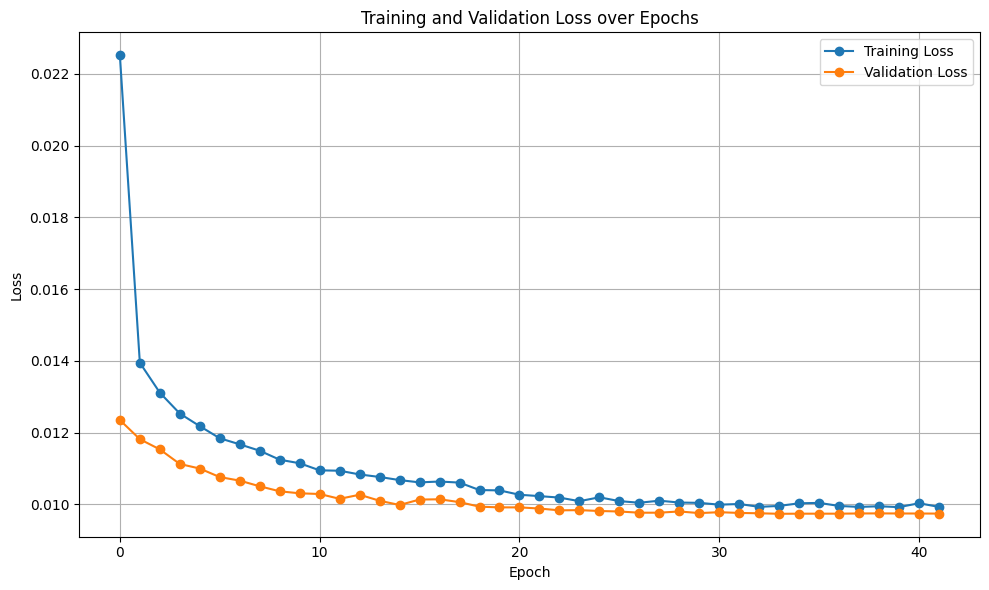

In [20]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer

# === Setup paths ===

report_path = os.path.join(main_directory, "finetuned_e5_evaluation_reports_dense_updated.txt")

# === Load data ===
df_train = pd.read_csv(main_directory + "df_train.csv")
df_test = pd.read_csv(main_directory + "df_test.csv")
df_all = pd.read_csv(main_directory + "uspto_patents_cpc_metadata.csv")
embeddings = np.load(main_directory + "fine_tuned_patent_model.npy")

df_all["publication_number"] = df_all["publication_number"].astype(str)
df_train["publication_number"] = df_train["publication_number"].astype(str)
df_test["publication_number"] = df_test["publication_number"].astype(str)

# === Multi-label Binarizer ===
df_all['section_list'] = df_all['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H", "Y"])
Y_all = mlb.fit_transform(df_all["section_list"])

from sklearn.utils import resample

# === Build lookup index ===
pub_to_index = {pub: idx for idx, pub in enumerate(df_all["publication_number"])}

# === Add section flags ===
df_all['is_D'] = df_all['section_list'].apply(lambda s: 'D' in s)
df_all['is_Y'] = df_all['section_list'].apply(lambda s: 'Y' in s)

# === Merge label info into df_train ===
df_train_full = pd.merge(
    df_train,
    df_all[['publication_number', 'section_list', 'is_D', 'is_Y']],
    on='publication_number',
    how='left'
)

# === Separate majority/minority sets ===
df_majority = df_train_full[(~df_train_full['is_D']) & (~df_train_full['is_Y'])]
df_minority = df_train_full[(df_train_full['is_D']) | (df_train_full['is_Y'])]

# === Oversample minority classes to match majority size ===
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# === Combine and finalize training set ===
df_train_balanced = pd.concat([df_majority, df_minority_upsampled]).drop_duplicates(subset='publication_number')

# === Match to embeddings and labels ===
train_indices = df_train_balanced["publication_number"].map(pub_to_index).dropna().astype(int).tolist()
test_indices = df_test["publication_number"].map(pub_to_index).dropna().astype(int).tolist()

X_train = embeddings[train_indices]
y_train = Y_all[train_indices]

X_test = embeddings[test_indices]
y_test = Y_all[test_indices]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# === Get embedding dimension ===
embedder = SentenceTransformer(main_directory + "fine_tuned_patent_model")
EMBEDDING_DIM = embedder.get_sentence_embedding_dimension()
NUM_CLASSES = y_train.shape[1]

# === Custom Focal Loss ===
def binary_focal_loss(gamma=3.0, alpha=0.1):
    def focal_loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * K.pow(1. - pt, gamma) * K.log(pt)
        return K.mean(loss, axis=-1)
    return focal_loss

# === Build Improved Dense Model ===
input_layer = Input(shape=(EMBEDDING_DIM,))
x = Dense(256, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(NUM_CLASSES, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=binary_focal_loss(gamma=2.0, alpha=0.25),
              metrics=['accuracy'])

model.summary()

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === Train/Val Split ===
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

# === Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# === Train Model ===
history = model.fit(X_train_final, y_train_final,
                    validation_data=(X_val, y_val),
                    batch_size=256,
                    epochs=100,
                    callbacks=[early_stop, lr_scheduler])

# === Apply Model to Test Data ===
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# === Evaluation ===
report = classification_report(y_test, y_pred_binary, target_names=mlb.classes_)
print(report)

# === Save Report ===
with open(report_path, "a") as f:
    f.write("Model summary:\n")
    model.summary(print_fn=lambda x: f.write(x + "\n"))
    f.write("\nClassification Report:\n")
    f.write(report)

# === Plot Training and Validation Loss ===
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(main_directory, "loss_curve_updated.png"))
plt.show()

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import numpy as np
import os

# Define where to store the results
report_path = os.path.join(main_directory, "original_e5_v2_evaluation_reports-8-2.txt")
with open(report_path, "w") as f:
    f.write(" Multi-Label Classification Report\n\n")

# === Classifiers to evaluate ===
models = {
    # "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs'),
    "Linear SVM": LinearSVC(max_iter=1000, class_weight='balanced'),
    # "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
}

for name, base_model in models.items():
    print(f"\n Training multi-label classifier: {name}")

    try:
        clf = OneVsRestClassifier(base_model)
        clf.fit(X_train, y_train)

        y_test_pred = clf.predict(X_test)
        test_report = classification_report(y_test, y_test_pred, target_names=mlb.classes_)

        print(f"\n Test Report for {name}:")
        print(test_report)

        # Save to file
        with open(report_path, "a") as f:
            f.write(f"\n=== {name} ===\n")
            f.write("Test Report:\n")
            f.write(test_report + "\n")
            f.write("=" * 60 + "\n")

    except Exception as e:
        print(f" Error with {name}: {e}")
        with open(report_path, "a") as f:
            f.write(f"\n Error with {name}: {e}\n")



 Training multi-label classifier: Logistic Regression

 Test Report for Logistic Regression:
              precision    recall  f1-score   support

           A       0.84      0.87      0.86       647
           B       0.68      0.75      0.71       622
           C       0.70      0.83      0.76       367
           D       0.08      0.80      0.14        30
           E       0.26      0.85      0.40        99
           F       0.49      0.77      0.60       226
           G       0.87      0.79      0.83      1256
           H       0.88      0.82      0.85      1270
           Y       0.03      0.58      0.05        31

   micro avg       0.64      0.81      0.71      4548
   macro avg       0.54      0.79      0.58      4548
weighted avg       0.79      0.81      0.79      4548
 samples avg       0.78      0.87      0.78      4548


 Training multi-label classifier: Linear SVM

 Test Report for Linear SVM:
              precision    recall  f1-score   support

           A    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import numpy as np
import os

# ====== Set your manual threshold here ======
threshold = 0.35  # You can adjust this

# ===== SimpleMoE Classifier =====
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleMoEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, experts):
        self.experts = experts

    def fit(self, X, y):
        for _, model in self.experts:
            model.fit(X, y)
        return self

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= threshold).astype(int)

    def predict_proba(self, X):
        probas = []
        for _, model in self.experts:
            if hasattr(model, "predict_proba"):
                proba = model.predict_proba(X)
                if proba.shape[1] == 2:
                    proba = proba[:, 1]  # use positive class
                probas.append(proba)
            else:
                # Fallback for models without predict_proba
                probas.append(model.predict(X))
        avg_proba = np.mean(probas, axis=0)
        return np.vstack([1 - avg_proba, avg_proba]).T  # shape: (n_samples, 2)

# ===== Define Ensemble Experts =====
experts = [
    ("lr", LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')),
    ("svc", CalibratedClassifierCV(LinearSVC(max_iter=1000, class_weight='balanced'))),
    #("lr", LogisticRegression(max_iter=1000, solver='lbfgs')),
    #("svc", CalibratedClassifierCV(LinearSVC(max_iter=1000))),
    ("knn", KNeighborsClassifier(n_neighbors=5))
]

# ===== Report Path =====
report_path = os.path.join(main_directory, "moe_finetuned_e5_evaluation_reports.txt")
with open(report_path, "w") as f:
    f.write(" Multi-Label Classification Report\n\n")

# ===== Train OneVsRest SimpleMoE =====
print("\n Training multi-label classifier: SimpleMoE (Threshold = {:.2f})".format(threshold))

try:
    base_moe = SimpleMoEClassifier(experts)
    clf = OneVsRestClassifier(base_moe)
    clf.fit(X_train, y_train)

    y_test_pred = clf.predict(X_test)
    test_report = classification_report(y_test, y_test_pred, target_names=mlb.classes_)

    print(f"\n Test Report for SimpleMoE (Threshold = {threshold}):")
    print(test_report)

    # Save report to file
    with open(report_path, "a") as f:
        f.write(f"\n=== SimpleMoE (Threshold = {threshold}) ===\n")
        f.write("Test Report:\n")
        f.write(test_report + "\n")
        f.write("=" * 60 + "\n")

except Exception as e:
    print(f" Error with SimpleMoE: {e}")
    with open(report_path, "a") as f:
        f.write(f"\n Error with SimpleMoE: {e}\n")



 Training multi-label classifier: SimpleMoE (Threshold = 0.35)

 Test Report for SimpleMoE (Threshold = 0.35):
              precision    recall  f1-score   support

           A       0.88      0.85      0.87       647
           B       0.77      0.70      0.73       622
           C       0.80      0.80      0.80       367
           D       0.57      0.27      0.36        30
           E       0.62      0.62      0.62        99
           F       0.74      0.66      0.70       226
           G       0.87      0.79      0.83      1256
           H       0.89      0.82      0.85      1270
           Y       1.00      0.03      0.06        31

   micro avg       0.84      0.78      0.81      4548
   macro avg       0.79      0.61      0.65      4548
weighted avg       0.84      0.78      0.81      4548
 samples avg       0.89      0.85      0.84      4548



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


X_train shape: (13746, 768)
X_test shape: (3437, 768)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,601 (932.04 KB)

 Trainable params: 238,601 (932.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5559 - loss: 0.0299 - val_accuracy: 0.8327 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8146 - loss: 0.0127 - val_accuracy: 0.8327 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8200 - loss: 0.0119 - val_accuracy: 0.8307 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8190 - loss: 0.0114 - val_accuracy: 0.8298 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8180 - loss: 0.0111 - val_accuracy: 0.8274 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8194 - loss: 0.0107 - val_accuracy: 0.8269 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8262 - loss: 0.0104 - val_ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


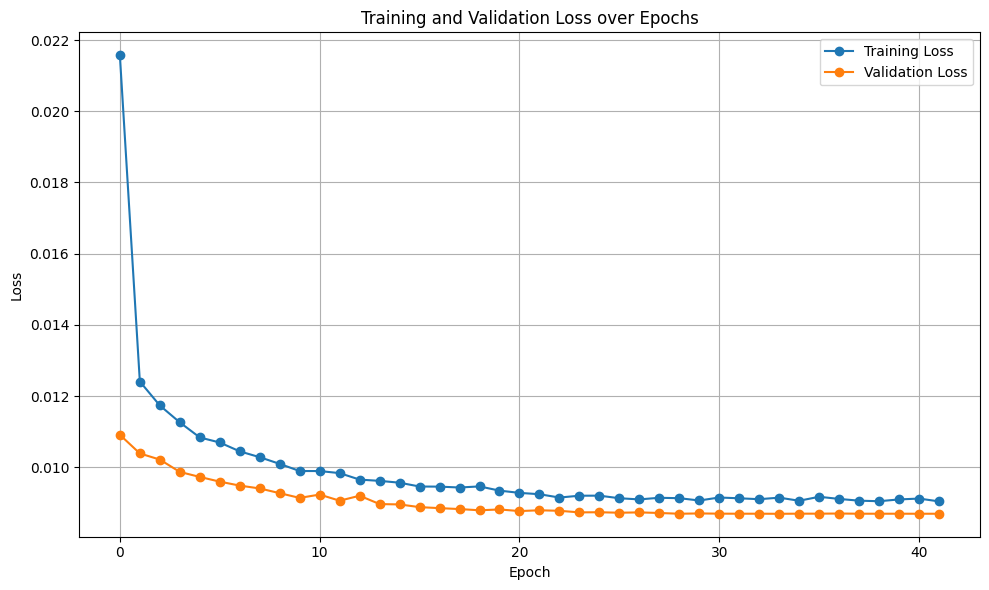

In [12]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer

# === Setup paths ===

report_path = os.path.join(main_directory, "finetuned_e5_evaluation_reports_dense_updated-8-1.txt")

df_all["publication_number"] = df_all["publication_number"].astype(str)
df_train["publication_number"] = df_train["publication_number"].astype(str)
df_test["publication_number"] = df_test["publication_number"].astype(str)

# === Multi-label Binarizer ===
df_all['section_list'] = df_all['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H", "Y"])
Y_all = mlb.fit_transform(df_all["section_list"])

from sklearn.utils import resample

# === Build lookup index ===
pub_to_index = {pub: idx for idx, pub in enumerate(df_all["publication_number"])}

# === Add section flags ===
df_all['is_D'] = df_all['section_list'].apply(lambda s: 'D' in s)
df_all['is_Y'] = df_all['section_list'].apply(lambda s: 'Y' in s)

# === Merge label info into df_train ===
df_train_full = pd.merge(
    df_train,
    df_all[['publication_number', 'section_list', 'is_D', 'is_Y']],
    on='publication_number',
    how='left'
)

# === Separate majority/minority sets ===
df_majority = df_train_full[(~df_train_full['is_D']) & (~df_train_full['is_Y'])]
df_minority = df_train_full[(df_train_full['is_D']) | (df_train_full['is_Y'])]

# === Oversample minority classes to match majority size ===
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# === Combine and finalize training set ===
df_train_balanced = pd.concat([df_majority, df_minority_upsampled]).drop_duplicates(subset='publication_number')

# === Match to embeddings and labels ===
train_indices = df_train_balanced["publication_number"].map(pub_to_index).dropna().astype(int).tolist()
test_indices = df_test["publication_number"].map(pub_to_index).dropna().astype(int).tolist()

X_train = embeddings[train_indices]
y_train = Y_all[train_indices]

X_test = embeddings[test_indices]
y_test = Y_all[test_indices]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# === Get embedding dimension ===
embedder = SentenceTransformer(main_directory + "fine_tuned_patent_model")
EMBEDDING_DIM = embedder.get_sentence_embedding_dimension()
NUM_CLASSES = y_train.shape[1]

# === Custom Focal Loss ===
def binary_focal_loss(gamma=3.0, alpha=0.1):
    def focal_loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * K.pow(1. - pt, gamma) * K.log(pt)
        return K.mean(loss, axis=-1)
    return focal_loss

# === Build Improved Dense Model ===
input_layer = Input(shape=(EMBEDDING_DIM,))
x = Dense(256, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(NUM_CLASSES, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=binary_focal_loss(gamma=2.0, alpha=0.25),
              metrics=['accuracy'])

model.summary()

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === Train/Val Split ===
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

# === Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# === Train Model ===
history = model.fit(X_train_final, y_train_final,
                    validation_data=(X_val, y_val),
                    batch_size=256,
                    epochs=100,
                    callbacks=[early_stop, lr_scheduler])

# === Apply Model to Test Data ===
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# === Evaluation ===
report = classification_report(y_test, y_pred_binary, target_names=mlb.classes_)
print(report)

# === Save Report ===
with open(report_path, "a") as f:
    f.write("Model summary:\n")
    model.summary(print_fn=lambda x: f.write(x + "\n"))
    f.write("\nClassification Report:\n")
    f.write(report)

# === Plot Training and Validation Loss ===
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(main_directory, "loss_curve_updated.png"))
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC

from sklearn.metrics import log_loss

ml_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(probability=True)
}

loss_curves = {}

for name, base_model in ml_models.items():
    print(f"\n=== Training {name} ===")
    model = MultiOutputClassifier(base_model)
    model.fit(X_train_final, y_train_final)

    # Predict probabilities for log loss
    y_train_pred_proba = model.predict_proba(X_train_final)
    y_val_pred_proba = model.predict_proba(X_val)

    # Convert tuple output to array
    y_train_proba = np.array([p[:, 1] if p.ndim > 1 else p for p in y_train_pred_proba]).T
    y_val_proba = np.array([p[:, 1] if p.ndim > 1 else p for p in y_val_pred_proba]).T

    # Compute log loss (binary cross-entropy)
    train_loss = log_loss(y_train_final, y_train_proba)
    val_loss = log_loss(y_val, y_val_proba)
    loss_curves[name] = (train_loss, val_loss)

    # Classification report on test set
    y_test_pred = model.predict(X_test)
    report = classification_report(y_test, y_test_pred, target_names=mlb.classes_)
    print(report)

    report_file = os.path.join(main_directory, f"{name.lower().replace(' ', '_')}_report.txt")
    with open(report_file, "w") as f:
        f.write(f"{name} Classification Report\n")
        f.write(report)



=== Training Logistic Regression ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           A       0.87      0.79      0.83       647
           B       0.77      0.58      0.66       622
           C       0.86      0.66      0.75       367
           D       0.50      0.03      0.06        30
           E       0.68      0.56      0.61        99
           F       0.73      0.55      0.63       226
           G       0.84      0.77      0.80      1256
           H       0.88      0.77      0.82      1270
           Y       0.00      0.00      0.00        31

   micro avg       0.84      0.71      0.77      4548
   macro avg       0.68      0.52      0.57      4548
weighted avg       0.83      0.71      0.76      4548
 samples avg       0.86      0.78      0.80      4548


=== Training KNN ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           A       0.88      0.83      0.85       647
           B       0.73      0.62      0.67       622
           C       0.82      0.75      0.78       367
           D       0.59      0.33      0.43        30
           E       0.65      0.56      0.60        99
           F       0.70      0.56      0.62       226
           G       0.81      0.79      0.80      1256
           H       0.86      0.79      0.82      1270
           Y       1.00      0.03      0.06        31

   micro avg       0.82      0.74      0.78      4548
   macro avg       0.78      0.59      0.63      4548
weighted avg       0.81      0.74      0.77      4548
 samples avg       0.85      0.81      0.80      4548


=== Training SVC ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           A       0.90      0.79      0.84       647
           B       0.78      0.56      0.65       622
           C       0.86      0.70      0.77       367
           D       0.67      0.33      0.44        30
           E       0.75      0.52      0.61        99
           F       0.76      0.52      0.62       226
           G       0.84      0.76      0.80      1256
           H       0.89      0.76      0.82      1270
           Y       0.00      0.00      0.00        31

   micro avg       0.85      0.71      0.77      4548
   macro avg       0.72      0.55      0.62      4548
weighted avg       0.84      0.71      0.77      4548
 samples avg       0.87      0.78      0.80      4548



In [15]:
from sklearn.metrics import classification_report

# === Predict probabilities on test set ===

# 1. Neural Network (already defined as `model`)
nn_probs = model.predict(X_test)

# 2. Logistic Regression
logreg = MultiOutputClassifier(LogisticRegression(max_iter=1000)).fit(X_train_final, y_train_final)
logreg_probs_raw = logreg.predict_proba(X_test)
logreg_probs = np.array([p[:, 1] if p.ndim > 1 else p for p in logreg_probs_raw]).T

# 3. KNN
knn = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5)).fit(X_train_final, y_train_final)
knn_probs_raw = knn.predict_proba(X_test)
knn_probs = np.array([p[:, 1] if p.ndim > 1 else p for p in knn_probs_raw]).T

# 4. SVC
svc = MultiOutputClassifier(SVC(probability=True)).fit(X_train_final, y_train_final)
svc_probs_raw = svc.predict_proba(X_test)
svc_probs = np.array([p[:, 1] if p.ndim > 1 else p for p in svc_probs_raw]).T

# === Average Ensemble ===
ensemble_probs = (nn_probs + logreg_probs + knn_probs + svc_probs) / 4.0
ensemble_pred = (ensemble_probs > 0.5).astype(int)

# === Evaluation ===
ensemble_report = classification_report(y_test, ensemble_pred, target_names=mlb.classes_)
print("\n=== Ensemble Model Report ===\n")
print(ensemble_report)

# === Save Report ===
ensemble_report_path = os.path.join(main_directory, "ensemble_model_report.txt")
with open(ensemble_report_path, "w") as f:
    f.write("Ensemble Model Classification Report\n")
    f.write(ensemble_report)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Ensemble Model Report ===

              precision    recall  f1-score   support

           A       0.90      0.79      0.84       647
           B       0.78      0.56      0.65       622
           C       0.86      0.70      0.77       367
           D       0.67      0.33      0.44        30
           E       0.75      0.52      0.61        99
           F       0.76      0.52      0.62       226
           G       0.84      0.77      0.80      1256
           H       0.89      0.76      0.82      1270
           Y       0.00      0.00      0.00        31

   micro avg       0.85      0.71      0.77      4548
   macro avg       0.72      0.55      0.62      4548
weighted avg       0.84      0.71      0.77      4548
 samples avg       0.87      0.78      0.80      4548



In [ ]:
if not os.path.exists(model_directory + "e5-base-v2_embeddings_df_cleaned_tuned.npy"):
  # Initialize embedding model
  embedder = SentenceTransformer(model_directory + "fine_tuned_patent_model_e5-base-v2")
  #Create embeddings
  embeddings = embedder.encode(df_cleaned["combined_text"].tolist())
  np.save(model_directory + "e5-base-v2_embeddings_df_cleaned_tuned.npy", embeddings)
else:
    print("Tuned embeddings already exist for df_cleaned split.")
    embeddings = np.load(model_directory + "e5-base-v2_embeddings_df_cleaned_tuned.npy")


Tuned embeddings already exist for df_cleaned split.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report


# Step 1: Preprocess labels (multi-label binarization)
# The filtering for missing 'section' values was already done when creating df_cleaned from df_all
# No need to dropna again here.
#embeddings = embedder.encode(df_cleaned["combined_text"].tolist())

# Split section into list (if it's a comma-separated string)
df_cleaned['section_list'] = df_cleaned['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Binarize multi-label output
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H", "Y"])
Y = mlb.fit_transform(df_cleaned["section_list"])


# Step 2: Train-test split
# Since embeddings were created from df_cleaned (after the initial split and dropping missing sections),
# we can use the index of this df_cleaned directly as it corresponds to the embeddings.
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, test_size=0.5, random_state=42
)

# Step 3: Train a One-vs-Rest classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = clf.predict(X_test)
print("Multi-label Section Classification Report (OneVsRestClassifier) on df_cleaned split with finetuned embeddings:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Multi-label Section Classification Report (OneVsRestClassifier) on df_cleaned split with finetuned embeddings:

              precision    recall  f1-score   support

           A       0.95      0.84      0.89      1312
           B       0.90      0.69      0.78      1214
           C       0.92      0.80      0.85       771
           D       0.86      0.37      0.51        49
           E       0.94      0.69      0.79       199
           F       0.89      0.68      0.77       500
           G       0.91      0.83      0.87      2445
           H       0.93      0.84      0.88      2415
           Y       1.00      0.02      0.04        47

   micro avg       0.92      0.79      0.85      8952
   macro avg       0.92      0.64      0.71      8952
weighted avg       0.92      0.79      0.85      8952
 samples avg       0.94      0.87      0.88      8952



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Use a logistic regression based classifier
from sklearn.linear_model import LogisticRegression

clf = OneVsRestClassifier(LogisticRegression(
    max_iter=1000,
    solver='lbfgs'
))
clf.fit(X_train, y_train)

# ------------------------------------------------
# STEP 5: Predict & Evaluate
# ------------------------------------------------

y_pred = clf.predict(X_test)
# Classification report
print("Multi-label LogisticRegression Section Classification Report on df_cleaned split with finetuned embeddings:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


Multi-label LogisticRegression Section Classification Report on df_cleaned split with finetuned embeddings:
              precision    recall  f1-score   support

           A       0.94      0.81      0.87      1312
           B       0.92      0.69      0.79      1214
           C       0.95      0.72      0.82       771
           D       0.00      0.00      0.00        49
           E       0.93      0.70      0.80       199
           F       0.90      0.71      0.79       500
           G       0.94      0.80      0.87      2445
           H       0.94      0.82      0.87      2415
           Y       0.00      0.00      0.00        47

   micro avg       0.94      0.77      0.84      8952
   macro avg       0.72      0.58      0.65      8952
weighted avg       0.93      0.77      0.84      8952
 samples avg       0.95      0.85      0.88      8952



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# -------------------------
# XGBoost Model
# -------------------------
from xgboost import XGBClassifier

xgb_params = {
    "objective": "binary:logistic",  # Required for multilabel
    "eval_metric": "logloss",
    "use_label_encoder": False,
    "n_estimators": 100,
    "max_depth": 5,
    "learning_rate": 0.1,
}

clf = OneVsRestClassifier(XGBClassifier(**xgb_params))
clf.fit(X_train, y_train)

# -------------------------
# Step 5: Prediction
# -------------------------
y_pred = clf.predict(X_test)

print("Multi-label XGBoost Section Classification Report on df_cleaned split with finetuned embeddings:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:55:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:56:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:56:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:56:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:56:13] WARNING: /w

Multi-label XGBoost Section Classification Report on df_cleaned split with finetuned embeddings:
              precision    recall  f1-score   support

           A       0.94      0.84      0.89      1312
           B       0.89      0.71      0.79      1214
           C       0.90      0.81      0.85       771
           D       0.90      0.55      0.68        49
           E       0.92      0.69      0.79       199
           F       0.89      0.69      0.78       500
           G       0.91      0.84      0.87      2445
           H       0.92      0.84      0.88      2415
           Y       1.00      0.02      0.04        47

   micro avg       0.91      0.80      0.85      8952
   macro avg       0.92      0.66      0.73      8952
weighted avg       0.91      0.80      0.85      8952
 samples avg       0.94      0.87      0.88      8952



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


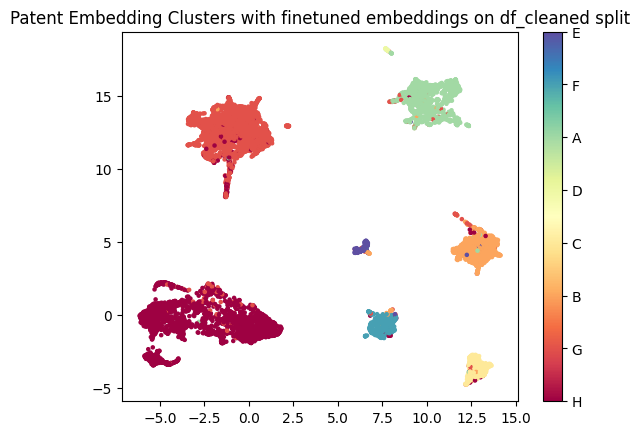

In [ ]:
import umap
import matplotlib.pyplot as plt

valid_sections = list("ABCDEFGHY")
df_cleaned_tmp = df_cleaned[df_cleaned["section"].isin(valid_sections)]

reducer = umap.UMAP(n_neighbors=15, random_state=42)
# Compute UMAP projection only on embeddings corresponding to df_cleaned
proj = reducer.fit_transform(embeddings[df_cleaned_tmp.index])

# Define labels for coloring the scatter plot
labels = df_cleaned_tmp["section"]

# Map string labels to numerical values
unique_labels = labels.unique()
label_map = {label: i for i, label in enumerate(unique_labels)}
numerical_labels = labels.map(label_map)


plt.scatter(proj[:,0], proj[:,1], c=numerical_labels, cmap='Spectral', s=5)
plt.title("Patent Embedding Clusters with finetuned embeddings on df_cleaned split")
# Add a colorbar to show the mapping of colors to sections
cbar = plt.colorbar(ticks=np.arange(len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

embeddings = embedder.encode(test_df["combined_text"].tolist())

# Split section into list (if it's a comma-separated string)
test_df['section_list'] = test_df['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Binarize multi-label output
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H", "Y"])
Y = mlb.fit_transform(test_df["section_list"])


# Step 2: Train-test split
# Since embeddings were created from df_cleaned (after the initial split and dropping missing sections),
# we can use the index of this df_cleaned directly as it corresponds to the embeddings.
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, test_size=0.5, random_state=42
)

# Step 3: Train a One-vs-Rest classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = clf.predict(X_test)
print("Multi-label Section Classification Report (OneVsRestClassifier) on test_df split with finetuned embeddings:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Multi-label Section Classification Report (OneVsRestClassifier) on test_df split with finetuned embeddings:

              precision    recall  f1-score   support

           A       0.90      0.79      0.84       314
           B       0.78      0.59      0.67       314
           C       0.86      0.80      0.83       186
           D       1.00      0.05      0.10        19
           E       0.65      0.57      0.61        49
           F       0.79      0.48      0.59       109
           G       0.81      0.78      0.79       599
           H       0.88      0.79      0.83       634
           Y       0.00      0.00      0.00        18

   micro avg       0.84      0.73      0.78      2242
   macro avg       0.74      0.54      0.59      2242
weighted avg       0.83      0.73      0.77      2242
 samples avg       0.85      0.79      0.80      2242



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Use a logistic regression based classifier
from sklearn.linear_model import LogisticRegression

clf = OneVsRestClassifier(LogisticRegression(
    max_iter=1000,
    solver='lbfgs'
))
clf.fit(X_train, y_train)

# ------------------------------------------------
# STEP 5: Predict & Evaluate
# ------------------------------------------------

y_pred = clf.predict(X_test)

# Classification report
print("Multi-label LogisticRegression Section Classification Report on test_df split with finetuned embeddings:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


Multi-label LogisticRegression Section Classification Report on test_df split with finetuned embeddings:
              precision    recall  f1-score   support

           A       0.89      0.76      0.82       314
           B       0.79      0.57      0.66       314
           C       0.89      0.70      0.78       186
           D       0.00      0.00      0.00        19
           E       0.69      0.55      0.61        49
           F       0.76      0.55      0.64       109
           G       0.86      0.74      0.80       599
           H       0.90      0.77      0.83       634
           Y       0.00      0.00      0.00        18

   micro avg       0.86      0.70      0.77      2242
   macro avg       0.64      0.52      0.57      2242
weighted avg       0.84      0.70      0.76      2242
 samples avg       0.87      0.77      0.80      2242



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# -------------------------
# XGBoost Model
# -------------------------
from xgboost import XGBClassifier

xgb_params = {
    "objective": "binary:logistic",  # Required for multilabel
    "eval_metric": "logloss",
    "use_label_encoder": False,
    "n_estimators": 100,
    "max_depth": 5,
    "learning_rate": 0.1,
}

clf = OneVsRestClassifier(XGBClassifier(**xgb_params))
clf.fit(X_train, y_train)

# -------------------------
# Step 5: Prediction
# -------------------------
y_pred = clf.predict(X_test)

print("Multi-label XGBoost Section Classification Report on test_df split with finetuned embeddings:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:55:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:55:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:55:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:55:37] WARNING: /w

Multi-label XGBoost Section Classification Report on test_df split with finetuned embeddings:
              precision    recall  f1-score   support

           A       0.89      0.80      0.84       314
           B       0.77      0.60      0.68       314
           C       0.84      0.80      0.82       186
           D       0.67      0.21      0.32        19
           E       0.65      0.57      0.61        49
           F       0.71      0.50      0.58       109
           G       0.81      0.77      0.79       599
           H       0.86      0.79      0.83       634
           Y       0.00      0.00      0.00        18

   micro avg       0.83      0.73      0.78      2242
   macro avg       0.69      0.56      0.61      2242
weighted avg       0.82      0.73      0.77      2242
 samples avg       0.84      0.79      0.80      2242



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
cpc_class_map = {
    "A01": "Agriculture; Forestry; Animal Husbandry; Hunting; Trapping; Fishing",
    "A21": "Baking; Equipment for making or processing doughs; Doughs for baking",
    "A22": "Butchering; Meat treatment; Processing poultry or fish",
    "A23": "Foods or foodstuffs; Their treatment, not covered by other classes",
    "A24": "Tobacco; Cigars; Cigarettes; Smokers' requisites",
    "A41": "Wearing apparel",
    "A42": "Headwear",
    "A43": "Footwear",
    "A44": "Haberdashery; Jewelry",
    "A45": "Hand or travelling articles",
    "A46": "Brushware",
    "A47": "Furniture; Domestic articles or appliances",
    "A61": "Medical or veterinary science; Hygiene",
    "A62": "Life-saving; Fire-fighting",
    "A63": "Sports; Games; Amusements",
    "B01": "General physical or chemical methods or apparatus",
    "B02": "Crushing, pulverising, or disintegrating; Preparatory treatment of grain",
    "B03": "Separation of solid materials using liquids or using pneumatic tables or jigs",
    "B04": "Centrifugal apparatus or machines for carrying-out physical or chemical processes",
    "B05": "Spraying or atomising in general; Applying liquids or other fluent materials to surfaces",
    "B06": "Generating or transmitting mechanical vibrations in general",
    "B07": "Separating solids from solids; Sorting",
    "B08": "Cleaning",
    "B09": "Waste disposal",
    "B21": "Mechanical metal-working without essentially removing material",
    "B22": "Casting; Powder metallurgy",
    "B23": "Machine tools; Metal-working not otherwise provided for",
    "B24": "Grinding; Polishing",
    "B25": "Hand tools; Portable power-driven tools; Handles for hand implements",
    "B26": "Hand cutting tools; Cutting; Severing",
    "B27": "Working or preserving wood or similar material",
    "B28": "Working cement, clay, or stone",
    "B29": "Working of plastics; Working of substances in a plastic state in general",
    "B30": "Presses",
    "B31": "Making paper articles or working paper",
    "B32": "Layered products",
    "B33": "Additive manufacturing technology",
    "B41": "Printing; Lining machines; Typewriters",
    "B42": "Bookbinding; Albums; Filing appliances",
    "B43": "Writing or drawing implements; Bureau accessories",
    "B44": "Decorative arts",
    "B60": "Vehicles in general",
    "B61": "Railways",
    "B62": "Land vehicles for travelling otherwise than on rails",
    "B63": "Ships or other waterborne vessels",
    "B64": "Aircraft; Aviation; Cosmonautics",
    "B65": "Conveying; Packing; Storing goods",
    "B66": "Hoisting; Lifting; Haulage",
    "B67": "Opening; Closing; Emptying; Refilling; Dispensing",
    "B68": "Saddlery; Upholstery",
    "B81": "Micro-structural technology; Micro-structural devices",
    "B82": "Nanotechnology",
    "C01": "Inorganic chemistry",
    "C02": "Treatment of water, waste water, sewage, or sludge",
    "C03": "Glass; Mineral or slag wool",
    "C04": "Cements; Concrete; Artificial stone; Ceramics",
    "C05": "Fertilizers; Manufacture thereof",
    "C06": "Explosives; Matches",
    "C07": "Organic chemistry",
    "C08": "Organic macromolecular compounds; their preparation or chemical working-up",
    "C09": "Dyes; Paints; Polishes; Adhesives; Compositions not otherwise provided for",
    "C10": "Petroleum, gas or coke industries; technical gases",
    "C11": "Animal or vegetable oils, fats, fatty substances",
    "C12": "Biochemistry; Beer; Spirits; Wine; Vinegar; Microbiology; Enzymology",
    "C13": "Sugar industry",
    "C14": "Skins; Hides; Pelts; Leather",
    "C21": "Metallurgy of iron",
    "C22": "Metallurgy; Ferrous or non-ferrous alloys; Treatment of alloys or metals",
    "C23": "Coating metallic material; Coating material with metallic material; Surface treatment",
    "C25": "Electrolytic or electrophoretic processes",
    "C30": "Crystal growth",
    "C40": "Combinatorial chemistry; Libraries thereof",
    "C99": "Subject matter not otherwise provided for in this section",
    "D01": "Natural or artificial threads or fibres; Spinning",
    "D02": "Yarns; Mechanical finishing of yarns or ropes",
    "D03": "Weaving",
    "D04": "Braiding; Lace-making; Knitting; Netting",
    "D05": "Sewing; Embroidering; Tufting",
    "D06": "Treatment of textiles or the like",
    "D07": "Ropes; Cables",
    "D10": "Paper-making; Production of cellulose",
    "D21": "Paper-making; Production of cellulose",
    "E01": "Construction of roads, railways, or bridges",
    "E02": "Hydraulic engineering; Foundations; Soil-shifting",
    "E03": "Water supply; Sewerage",
    "E04": "Building",
    "E05": "Locks; Keys; Window or door fittings",
    "E06": "Doors, windows, shutters, or roller blinds",
    "E21": "Earth or rock drilling; Mining",
    "F01": "Machines or engines in general; Engine plants in general",
    "F02": "Combustion engines",
    "F03": "Machines or engines for liquids",
    "F04": "Positive displacement machines for liquids; Pumps",
    "F15": "Fluid-pressure actuators; Hydraulic or pneumatic systems",
    "F16": "Engineering elements or units",
    "F17": "Storing or distributing gases or liquids",
    "F21": "Lighting",
    "F22": "Steam generation",
    "F23": "Combustion apparatus; Combustion processes",
    "F24": "Heating; Range; Ventilation",
    "F25": "Refrigeration or cooling",
    "F26": "Drying",
    "F27": "Furnaces; Kilns; Ovens; Retorts",
    "F28": "Heat-exchange apparatus",
    "F41": "Weapons",
    "F42": "Ammunition; Blasting",
    "G01": "Measuring; Testing",
    "G02": "Optics",
    "G03": "Photography; Cinematography; Apparatus or processes",
    "G04": "Horology",
    "G05": "Controlling; Regulating",
    "G06": "Computing; Calculating; Counting",
    "G07": "Checking-devices",
    "G08": "Signalling",
    "G09": "Educating; Cryptography; Display; Advertising; Seals",
    "G10": "Musical instruments; Acoustics",
    "G11": "Information storage",
    "G16": "Information and communication technology specially adapted for specific applications",
    "G21": "Nuclear physics; Nuclear engineering",
    "H01": "Basic electric elements",
    "H02": "Generation, conversion, or distribution of electric power",
    "H03": "Basic electronic circuitry",
    "H04": "Electric communication technique",
    "H05": "Electric techniques not otherwise provided for",
    "H99": "Subject matter not otherwise provided for in this section",
    "Y02": "Technologies or applications for mitigation or adaptation against climate change",
    "Y02A": "Technologies for adaptation to climate change",
    "Y02B": "Climate change mitigation technologies related to buildings (e.g., housing, appliances)",
    "Y02C": "Capture, storage, sequestration or disposal of greenhouse gases (GHG)",
    "Y02D": "Climate change mitigation technologies in ICT (aimed at reducing their own energy use)",
    "Y02E": "Reduction of GHG emissions related to energy generation, transmission or distribution",
    "Y02P": "Climate change mitigation technologies in the production or processing of goods",
    "Y02T": "Climate change mitigation technologies related to transportation",
    "Y02W": "Climate change mitigation technologies related to wastewater treatment or waste management",
    "Y04": "Information or communication technologies having an impact on other technology areas",
    "Y04S": "Systems integrating power network operations, communication, or IT for smart grids",
    "Y10": "Technical subjects covered by former USPC cross‑reference art collections",
    "Y10S": "Technical subjects covered by former USPC cross‑reference art collections (XRACs) and digests",
    "Y10T": "Technical subjects covered by former US (USPC) classification (post‑2015)"
}


In [25]:
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import numpy as np

# Step 1: Build a mapping from sections A–H, Y to CPC descriptions
section_descriptions = defaultdict(list)

for cpc_code, desc in cpc_class_map.items():
    section = cpc_code[0]  # First letter
    if section in "ABCDEFGHY":
        section_descriptions[section].append(desc)

# Step 2: Create a final string per section by joining descriptions
section_texts = {
    section: " ".join(descriptions)
    for section, descriptions in section_descriptions.items()
}

# Step 3: Embed each section text
embedder = SentenceTransformer(main_directory+"fine_tuned_patent_model")
#embedder = SentenceTransformer("intfloat/e5-base-v2")

section_embeddings = {
    section: embedder.encode(text)
    for section, text in section_texts.items()
}

# Step 4: Optional — Convert to matrix and print shape
section_matrix = np.vstack([section_embeddings[s] for s in "ABCDEFGHY"])
print("Section embedding matrix shape:", section_matrix.shape)  # (9, embedding_dim)


Section embedding matrix shape: (9, 768)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [26]:
section_embeddings = {
    section: embedder.encode(text)
    for section, text in section_texts.items()
}

# Step 4: Optional — Convert to matrix and print shape
section_matrix = np.vstack([section_embeddings[s] for s in "ABCDEFGHY"])
print("Section embedding matrix shape:", section_matrix.shape)  # (9, embedding_dim)

Section embedding matrix shape: (9, 768)


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# === SECTION EMBEDDINGS ===
section_order = list("ABCDEFGHY")
section_matrix = np.vstack([section_embeddings[s] for s in section_order])

# === COSINE SIMILARITY FEATURES ===
X_sim_all = cosine_similarity(embeddings, section_matrix)
X_train_sim = X_sim_all[train_indices]
X_test_sim = X_sim_all[test_indices]
y_train_sim = Y_all[train_indices]
y_test_sim = Y_all[test_indices]

# === TRAIN CLASSIFIER ===
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train_sim, y_train_sim)

# === PREDICT WITH CUSTOM THRESHOLD ===
threshold = 0.22 # Change this to tune sensitivity
y_proba = clf.predict_proba(X_test_sim)
y_pred_custom = (y_proba >= threshold).astype(int)

# === REPORT ===
print(f"\n=== MULTI-LABEL CLASSIFICATION REPORT (Threshold = {threshold}) ===")
print(classification_report(y_test_sim, y_pred_custom, target_names=section_order, zero_division=0))



=== MULTI-LABEL CLASSIFICATION REPORT (Threshold = 0.22) ===
              precision    recall  f1-score   support

           A       0.90      0.81      0.85       647
           B       0.78      0.66      0.71       622
           C       0.84      0.67      0.75       367
           D       0.00      0.00      0.00        30
           E       0.76      0.60      0.67        99
           F       0.75      0.62      0.68       226
           G       0.85      0.80      0.83      1256
           H       0.86      0.82      0.84      1270
           Y       0.00      0.00      0.00        31

   micro avg       0.85      0.76      0.80      4548
   macro avg       0.64      0.55      0.59      4548
weighted avg       0.83      0.76      0.79      4548
 samples avg       0.89      0.83      0.83      4548

